In [1]:
from shared_notebook_utils import *
from third_party.percival14_tempo.compute_bpm import compute_bpm as percival14_bpm 
from tempo_estimation.ffont16_tempo.compute_bpm import *
from ac_utils.plotting import annotate_point_pair
import essentia
import essentia.standard as estd
import random
seaborn.set(style="whitegrid")
%matplotlib inline
dataset = load_datasets(['freesound_loops_db_200'], clean=True)[0]

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Load a sound from the dataset
sound_id = None
if sound_id is None:
    selected_sound = random.choice(dataset.data.values())
else:
    selected_sound = dataset.data[str(sound_id)]
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
print 'Selected sound id: %s' % selected_sound['id']
print 'Selected sound path: %s' % sound_file_path
IPython.display.display(IPython.display.Audio(sound_file_path))

Selected sound id: 82237
Selected sound path: /Users/ffont/Data/AudioCommons/freesound_loops_db_200/audio/wav/82237.wav


# BPM detection algorithm (steps and plots)

In the following steps we run Percival's algorithm [1] including the different steps and plots of the different steps.
We do that using the simplification of the code in tempo_estimation.ffont16_tempo folder. We use this code as here we will add new stuff for the confidence measure etc, but the code for the BPM detection itself is exactly the same as Percival's.

[1] Percival, G., & Tzanetakis, G. (2014). Streamlined tempo estimation based on autocorrelation and cross-correlation with pulses. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 22(12), 1765–1776. Retrieved from http://dl.acm.org/citation.cfm?id=2719957

Audio samplerate: 44100.00 Hz, OSS samplerate 344.53 Hz
Ground truth BPM: 70.00
Estimated BPM: 70.00, 295 samples
Estimated BPM (percival14): 70.07, 295 samples


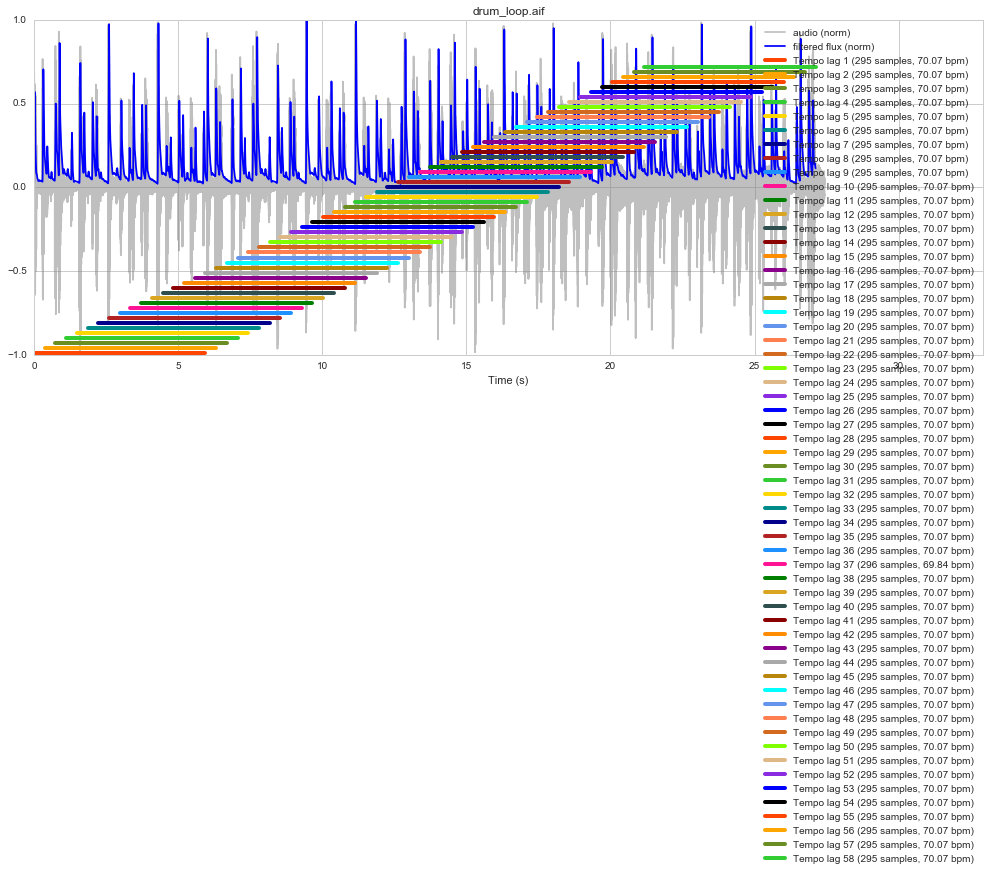

In [3]:
# NOTE: Most functions called in this cell are imported from "from tempo_estimation.ffont16_tempo.compute_bpm import *"

# Load audio file (selected in previous cell)
audio = load_audio_file(file_path=sound_file_path, sample_rate=44100)

# Set parameters
sample_rate=44100
plot=True
parameters = Parameters()

# Prepare plot
if plot:
    plt.figure(figsize=(17, 6))
    plt.title(selected_sound['name'])

# Prepare audio (convert to mono and zero pad)
audio = convert_to_mono(audio)
audio_length_before_zero_padding = len(audio)
audio = zero_padding_until_duration(audio, min_duration=6, sample_rate=sample_rate)
if plot:
    time = np.arange(float(len(audio))) / sample_rate
    plt.plot(time, normalize2(audio), label="audio (norm)", color="gray", alpha=0.5)
    
# Step 1) Compute onset strength signal
oss_sr, filtered_flux = onset_strength.onset_strength_signal(parameters, sample_rate, audio)
if plot:
    time = np.arange(float(len(filtered_flux))) / oss_sr
    plt.plot(time, normalize2(filtered_flux), label="filtered flux (norm)", color="blue")
    
# Step 2) Compute tempo lags for each window of 5.9s (0.37s hop) 
tempo_lags, all_combo_scores = beat_period_detection.beat_period_detection(parameters, oss_sr, filtered_flux)
if plot:
    for count, tempo_lag in enumerate(tempo_lags):
        # For each tempo lag, calculate which point in time corresponds to the middle of the window
        # This windowing happens directly to the OSS signal, therefore the sample rate that applies here
        # is that of the OSS signal
        t0 = float((count * parameters.BH_HOPSIZE)) / oss_sr
        t1 = float((count * parameters.BH_HOPSIZE) + parameters.BH_WINDOWSIZE) / oss_sr
        color = COLORS[count % (len(COLORS))]
        tempo_lag_bar_height = 0.5 / (len(tempo_lags))
        current_tempo_lag_bar_position = -0.99 + (count * 0.03)
        plt.plot([t0, t1], [current_tempo_lag_bar_position, current_tempo_lag_bar_position], 
                 label='Tempo lag %i (%i samples, %.2f bpm)' % 
                 (count + 1, tempo_lag, 60 * float(oss_sr)/tempo_lag), linewidth=4, color=color)
        
# Step 3) Estimate final bpm from tempo lags
bpm = accumulator_overall.accumulator_overall(parameters, tempo_lags, oss_sr)
bpm = round(bpm)  # Assume 1 bpm resolution (not .5 bpms)

# Add legend to plot and set appropriate axis
if plot:
    plt.axis([0, 1.2 * float(len(audio))/sample_rate, -1, 1])
    plt.legend(frameon=False)
    plt.xlabel('Time (s)')
    
print 'Audio samplerate: %.2f Hz, OSS samplerate %.2f Hz' % (float(sample_rate), float(oss_sr))
print 'Ground truth BPM: %.2f' % selected_sound['annotations']['bpm']
print 'Estimated BPM: %.2f, %i samples' % (bpm, tempo_lags[-1])
print 'Estimated BPM (percival14): %.2f, %i samples' % (percival14_bpm(sample_rate, audio))

# Confidence measure


We estimate a confidence measure based on comparing the length of the analysed file with the potential length that the file should assuming our BPM estimation is correct and the file has steady tempo. Given an estimated BPM value, we can produce a list of estimated lengths that the audio should have in number of samples: 

$$L^e[n] = \frac{60 \cdot SR \cdot n}{BPM^e}, $$ 

where $l^e[n]$ is the estimated length of the file in samples for a given number of beats $n$ in the range $1 \le n \le 128, n \in \mathbb{Z}$ , $SR$ is the sampling rate of the file and $BPM^e$ is the estimated BPM. The range for $n$ is taken such that it cosiders loops that last from only 1 beat to 128 beats, which would correspond to 32 bars in 4/4 meter. In practicum, what we need here is a number big enough such that we wont find loops longer than it.

Given the list of estimated lengths $L^e$ we need to see if any of its elements closely matches the actual length of the file (in samples). For that reason we compare the actual length of the file with all estimated lengths and keep the minimum difference found (in samples):

$$ \Delta l = min(|L^e - AL|),$$

where $AL$ is the actual lengtgh of the file (in samples). $AL$ is directly taken by measuring the length of the audio in samples from the file. Note that $L$ is a vector and $AL$ is a scalar, we subtract $AL$ to $L^e$ element-wise and take the absolute value. A value of $\Delta l$ close to 0 will mean that there is a close match between one of the estimated lengths and the actual length of the file. The confidence measure is based on quantifying how close this match is.

To do that, we define a threhsold $\lambda$ below which we consider $\Delta l$ being a close match. The threshold is defined as a fraction of the duration of a single beat given the estimated BPM:

$$ \lambda = k\frac{60 \cdot SR}{BPM^e}, $$

where $k$ is a parameter that must be set and that determines that fraction of the beat duration (ranging in $0 \le k \le 1, k \in \mathbb{R}$. The confidence measure is finally defined using the following formula: 

$$ confidence = \begin{cases} 
	0 & \text{if } \Delta l \gt \lambda \\
    1 - \frac{\Delta l}{\lambda} & \text{otherwise}\\
\end{cases}$$

Using this formula, confidence measures can take values from 0 to 1, where 1 indicates the maximum confidence that the $BPM^e$ estimate is correct. The reasoning behind that is that it is very unlikely that an audio file has a length which closely matches a multiple of the beast duration given an estimated BPM. If the audio file is perfectly cutted (sample accurate), it is possible that we find an exact match and thus get a confidence of 1. This method can however file if the audio file contains silence either at the beggining or at the end, making its length ($AL$) unrelated to the actual BPM. To account for this potential problem, we compute an alternative estimate of the length of the file ($AL'$) based on analysing the actual envelope of the signal, and repeat the confidence measure calculation process using that alternative estimated length. Our final confidence measure is taken as the maximum of confiences estimated with $AL$ and $AL'$.

TODO: explain computation of effective duration

The first method will work when audio loops are originally "cutted" perfectly or near perfectly. The other method will work also for cases in which the original audio had silence either before or after the loop starts (but might still fail if silence at the beggnining or the end is in fact part of the loop).


Ground truth BPM: 70.00
Detected BPM: 70.00
Audio length: 1209600
Confidence: 1.00  (0 samples diff, +/- 5670 samples tolerance)
    Effective audio length: 1209477
    Confidence: 0.98  (123 samples diff, +/- 5670 samples tolerance)
Final confidence: 1.00


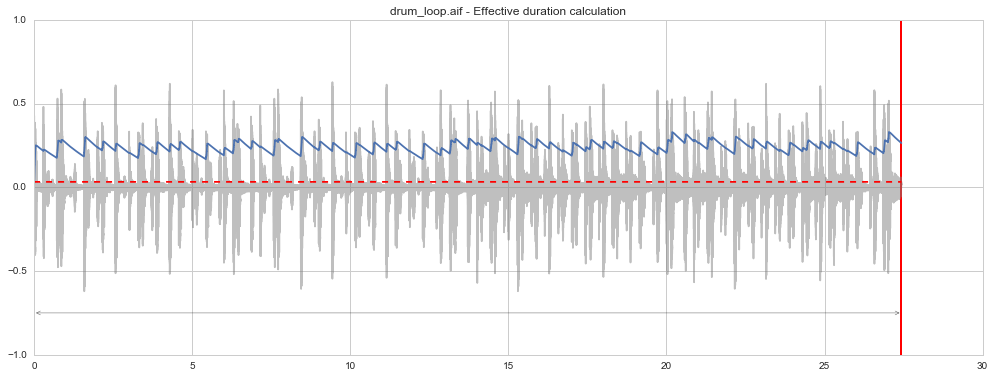

In [4]:
# Compare actual length of the audio with the different potential lengths (use modulus)
k = 0.15  # k is a fraction of a single beat, 15% of a beat duration in this case
# TODO: k = 0.15 has been decided in preliminary experiments with fs dataset 200
# The goal is to find a value which discards enough sounds but reaches good accuracies as linearly as possible with
# respect to the confidence value. This should be further explored and explained.
beat_duration = (60.0 * sample_rate)/bpm
L = [beat_duration * n for n in range(1, 128)]  # From 1 beat to 32 beats (would be 32 bars in 4/4)
thr_lambda = k * beat_duration
al = audio_length_before_zero_padding
delta_l = min([abs(l - al) for l in L])
if delta_l > thr_lambda:
    confidence = 0.0
else:
    confidence = 1.0 - float(delta_l) / thr_lambda
print 'Ground truth BPM: %.2f' % selected_sound['annotations']['bpm']
print 'Detected BPM: %.2f' % bpm
print 'Audio length: %i' % al
print 'Confidence: %.2f  (%i samples diff, +/- %i samples tolerance)' % (confidence, delta_l, thr_lambda)

# Compute envelope and effective duration of the audio
z = 0.1  # Percentage of the envelope amplitude that we use to compute start and end of signal
env = estd.Envelope()
envelope = env(essentia.array(audio))
env_threshold = envelope.max() * z
envelope_above_threshold = np.where(envelope >= env_threshold)
start_effective_duration = envelope_above_threshold[0][0]
end_effective_duration = envelope_above_threshold[0][-1]
al_alt = end_effective_duration - start_effective_duration
if plot:
    plt.figure(figsize=(17, 6))
    plt.title(selected_sound['name'] + ' - Effective duration calculation')
    time = np.arange(float(len(audio))) / sample_rate
    plt.plot(time, audio, label="audio", color="gray", alpha=0.5)
    plt.plot(time, envelope)
    plt.vlines(time[start_effective_duration], -1, 1, color='r', linewidth=2)
    plt.vlines(time[end_effective_duration], -1, 1, color='r', linewidth=2)
    plt.plot(time, env_threshold * np.ones(len(time)), color='r', linestyle='--')
    plt.annotate(s='', xy=(time[start_effective_duration],-0.75), xytext=(time[end_effective_duration],-0.75), arrowprops=dict(arrowstyle='<->'))

# Compare length base don effective duration of the audio with the different potential lengths (same method as before)
delta_l = min([abs(l - al_alt) for l in L])
if delta_l > thr_lambda:
    confidence_alt = 0.0
else:
    confidence_alt = 1.0 - float(delta_l) / thr_lambda
print '    Effective audio length: %i' % al_alt
print '    Confidence: %.2f  (%i samples diff, +/- %i samples tolerance)' % (confidence_alt, delta_l, thr_lambda)
print 'Final confidence: %.2f' % max(confidence_alt, confidence)

TODOS:

- octave chooser: introduce a bias for integer results? -> does not improve results
- check correlation between descriptors and prediction error?
- apple loops all have silence at the beggining? -> confirmed, by using confidence based on effective duration the accuracies improve, otherwise these are a bit noisy
- maybe use more time estimates in the confidences to account for silence at beggining, or silence at the end, or both silence (separated) -> does not improve results
- n onsets?

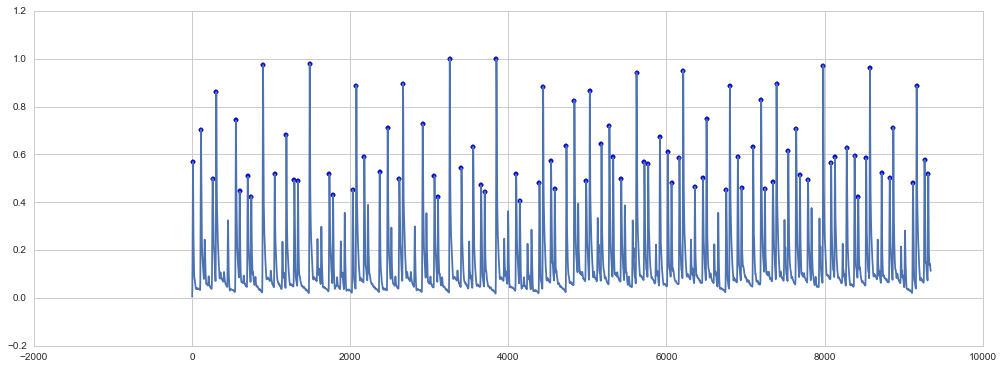

Flux peak count: 85
Flux peak rate: 3.10 peaks/second


In [5]:
plt.figure(figsize=(17, 6))
norm_flux = normalize2(filtered_flux)
plt.plot(norm_flux)
ind = detect_peaks(norm_flux, mph=0.4)  # 40% of maximum peak
plt.scatter(ind, norm_flux[ind])
plt.show()
peak_count = len(ind)
effective_duration_in_seconds = float(al_alt)/sample_rate
peak_rate = float(peak_count)/effective_duration_in_seconds
print 'Flux peak count: %i' % peak_count
print 'Flux peak rate: %.2f peaks/second' % peak_rate


Selected sound id: 63470
------------------------

Selected sound ground truth bpm: 140.00
Selected sound estimated bpm: 119.00
  Confidence: 0.59

Selected sound id: 43209
------------------------

Selected sound ground truth bpm: 91.00
Selected sound estimated bpm: 91.00
  Confidence for "Standard duration": 0.40
  Confidence for "Removed silence beginning": 0.70
  Confidence for "Removed silence end": 0.66
  Confidence for "Removed slience beginning and end": 0.97


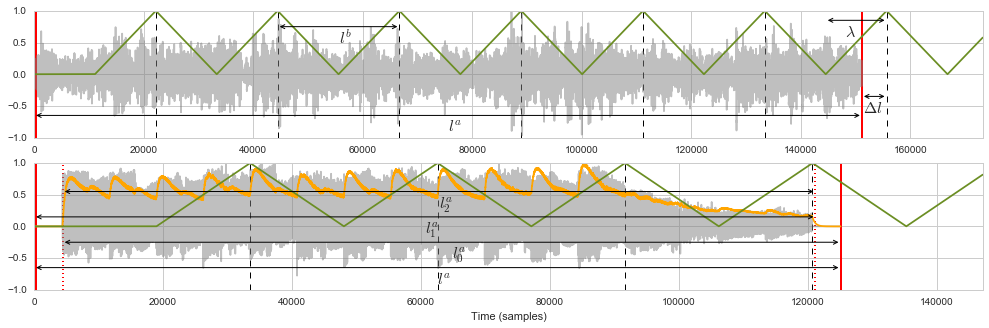

In [18]:
# Top of the figure: loop for which BPM estimation fails
########################################################
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 5))
sample_rate=44100

# Select and load sound
selected_sound = dataset.data['63470']
print title('Selected sound id: %s' % selected_sound['id'])
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
audio_1 = load_audio_file(file_path=sound_file_path, sample_rate=sample_rate)
bpm_1 = percival14_bpm(sample_rate, audio_1)[0]
bpm_1 = int(round(bpm_1))
print 'Selected sound ground truth bpm: %.2f' % selected_sound['annotations']['bpm']
print 'Selected sound estimated bpm: %.2f' % bpm_1

# Compute confidence based on "standard" audio signal duration
beat_duration = (60.0 * sample_rate)/bpm_1
L = [beat_duration * n for n in range(1, 128)]
thr_lambda = 0.5 * beat_duration
la = audio_1.shape[0]
delta_l = min([abs(l - la) for l in L])
if delta_l > thr_lambda:
    confidence_la = 0.0
else:
    confidence_la = (1.0 - float(delta_l) / thr_lambda)
print '  Confidence: %.2f' % confidence_la

# Plot
ax1.plot(normalize2(audio_1), color="gray", alpha=0.5)
ax1.vlines(L, -1, 1, color='black', linewidth=1, linestyle="--")
ax1.vlines([350, la], -1, 1, color='red', linewidth=2)
annotate_point_pair(ax1, r'$l^a$', (0, -0.65), (la, -0.65), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax1, r'$l^b$', (L[1], 0.75), (L[2], 0.75), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax1, r'$\Delta l$', (la, -0.35), (la + delta_l, -0.35), xycoords='data', text_offset=16, textx_offset=-2000, text_size=16)
annotate_point_pair(ax1, r'$\lambda$', (la + delta_l - thr_lambda, 0.85), (la + delta_l, 0.85), xycoords='data', text_offset=16, textx_offset=-2000, text_size=16)
confidence_output = list()
for i in range(0, la*2):
    delta = min([abs(l - i) for l in L])
    if delta > thr_lambda:
        confidence_output.append(0.0)
    else:
        value = 1.0 - float(delta) / thr_lambda
        confidence_output.append(value)
ax1.plot(confidence_output, color=COLORS[2])
ax1.set_xlim((0, la + 44100/2))
ax1.set_ylim((-1, 1))
#ax1.set_xlabel('Time (samples)')

# Bottom of the figure: loop for which BPM estimation works but that has silence at the beggining
#################################################################################################

# Select and load sound and add 100 ms silence at the beginning and at the end
selected_sound = dataset.data['43209']
print title('Selected sound id: %s' % selected_sound['id'])
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
audio_1 = load_audio_file(file_path=sound_file_path, sample_rate=sample_rate)
n_samples_silence = 4410
audio_2 = np.concatenate((np.zeros(n_samples_silence), audio_1, np.zeros(n_samples_silence)))
bpm_2 = percival14_bpm(sample_rate, audio_2)[0]
bpm_2 = int(round(bpm_2))
print 'Selected sound ground truth bpm: %.2f' % selected_sound['annotations']['bpm']
print 'Selected sound estimated bpm: %.2f' % bpm_2

# Compute confidence based on different durations
beat_duration = (60.0 * sample_rate)/bpm_2
L = [beat_duration * n for n in range(1, 128)]  # From 1 beat to 32 beats (would be 32 bars in 4/4)
thr_lambda = 0.5 * beat_duration
z = 0.05  # Percentage of the envelope amplitude that we use to compute start and end of signal
env = estd.Envelope(attackTime=10, releaseTime=10)
envelope = env(essentia.array(audio_2))
env_threshold = envelope.max() * z
envelope_above_threshold = np.where(envelope >= env_threshold)
start_effective_duration = envelope_above_threshold[0][0]
end_effective_duration = envelope_above_threshold[0][-1]
la = audio_2.shape[0]
durations_to_check = [
    ('Standard duration', la),
    ('Removed silence beginning', la - start_effective_duration),
    ('Removed silence end', end_effective_duration),
    ('Removed slience beginning and end', end_effective_duration - start_effective_duration)
]
for name, duration in durations_to_check:
    delta_l = min([abs(l - duration) for l in L])
    if delta_l > thr_lambda:
        confidence = 0.0
    else:
        confidence = (1.0 - float(delta_l) / thr_lambda)
    print '  Confidence for "%s": %.2f' % (name, confidence)

# Plot
ax2.plot(normalize2(audio_2), color="gray", alpha=0.5)
ax2.plot(normalize2(envelope), color=COLORS[1])
ax2.vlines([l + start_effective_duration for l in L], -1, 1, color='black', linewidth=1, linestyle="--")
ax2.vlines([start_effective_duration, end_effective_duration], -1, 1, color='red', linewidth=2, linestyle=":")
ax2.vlines([350, la], -1, 1, color='red', linewidth=2)
annotate_point_pair(ax2, r'$l^a$', (0, -0.65), (la, -0.65), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_0^a$', (start_effective_duration, -0.25), (la, -0.25), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_1^a$', (0, 0.15), (end_effective_duration, 0.15), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_2^a$', (start_effective_duration, 0.55), (end_effective_duration, 0.55), xycoords='data', text_offset=16, text_size=16)
confidence_output = list()
for i in range(0, la_alt*2):
    delta = min([abs(l - i) for l in L])
    if delta > thr_lambda:
        confidence_output.append(0.0)
    else:
        value = 1.0 - float(delta) / thr_lambda
        confidence_output.append(value)
confidence_output = list(np.zeros(start_effective_duration)) + confidence_output
ax2.plot(confidence_output, color=COLORS[2])
ax2.set_xlim((0, la + 44100/2))
ax2.set_ylim((-1, 1))
ax2.set_xlabel('Time (samples)')

fig.savefig(os.path.join(settings.TEMPO_ESTIMATION_OUT_PATH, 'confidence_measure_examples.pdf'))
plt.show()